## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from pathlib import Path
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# @title Styling
# @markdown Making things pretty! (This is meant to work with Colab's dark theme **(Settings > Site > Theme > "Dark")**.)
# import google
# is_dark = google.colab.output.eval_js(
#     'document.documentElement.matches("[theme=dark]")'
# )

matplotlib.rcParams["figure.dpi"] = 100
plt.rcParams["hatch.color"] = "white"

# if is_dark:
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)

plotly_template = pio.templates["plotly_dark"]
pio.templates["draft"] = go.layout.Template(
    layout=dict(
        plot_bgcolor="rgba(56,56,56,0)",
        paper_bgcolor="rgba(56,56,56,0)",
    )
)
pio.templates.default = "plotly_dark+draft"
    

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'device'
print(f"Using {device}")

Using cuda


## Net

In [4]:
from mlp import MLP
from heat import PINN_2D, BC, get_d

Using cuda
Using cuda


## Heat 2D

### 2D Diffusion with Spatially Varying Diffusivity Field

In [25]:

ADAPTIVE_SAMPLING = True
ADAPTIVE_WEIGHTING = True
t_bounds = [0, 16*np.pi]
s_bounds = [-4*np.pi, 4*np.pi]
d_fn = lambda pts: pts[:,1:2]*0 + 4
# d_fn = lambda pts: torch.sigmoid(pts[:,1:2]*6)*16 + torch.sigmoid(pts[:,2:3]*6)*8 + 0.2
d_fn = lambda pts: torch.sigmoid(torch.sqrt(torch.sum(pts[:,1:]**2,axis=1).reshape(-1,1) / (16*np.pi*np.pi)))*6 + 0.2
d_fn = lambda pts: torch.sigmoid(torch.sin(pts[:,1:2])*torch.sin(pts[:,2:3]))*6 + 0.2

# bc_l_fn = lambda pinn, pts: 1-torch.abs(pts[:,2:3]/pinn.y_range)*2
# bc_r_fn = lambda pinn, pts: bc_l_fn(pinn, pts)*-1
bc_l_fn = lambda pinn, pts: pts[:,1:2]*0
bc_r_fn = lambda pinn, pts: pts[:,1:2]*0 
bc_l_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_r_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_u_fn = lambda pinn, pts: pts[:,1:2]*0 + 2
bc_d_fn = lambda pinn, pts: pts[:,1:2]*0 + 2
bc_u_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_y"]
bc_d_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_y"]

gaussian_height = 15
gaussian_sigma = 5
ic_fn = lambda pinn, pts:  gaussian_height*(1/(gaussian_sigma*np.sqrt(2*np.pi)))*torch.exp(-(get_d(pts)**2) / (2*gaussian_sigma**2))
ic_fn = lambda pinn, pts: pts[:,1:2]*0
ic_pred_fn = lambda pinn, pts: pinn.net(pts)


bc_d = BC(
  ct=1000,
  truth_fn=bc_d_fn, 
  pred_fn=bc_d_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[0], s_bounds[0]]], 
  requires_grad=True,
)
bc_u = BC(
  ct=1000,
  truth_fn=bc_u_fn, 
  pred_fn=bc_u_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[1], s_bounds[1]]], 
  requires_grad=True,
)
bc_l = BC(
  ct=1000,
  truth_fn=bc_l_fn,
  pred_fn=bc_l_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[0], s_bounds[0]], s_bounds], 
  requires_grad=True,
)
bc_r = BC(
  ct=1000,
  truth_fn=bc_r_fn,
  pred_fn=bc_r_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[1], s_bounds[1]], s_bounds], 
  requires_grad=True,
)
ic = BC(
  ct=1000,
  truth_fn=ic_fn,
  pred_fn=ic_pred_fn,
  axis_bounds=[[t_bounds[0], t_bounds[0]], s_bounds, s_bounds], 
  requires_grad=False,
)
bcs = [bc_d, bc_u, bc_l, bc_r]
ics = [ic]

pinn = PINN_2D(
    net=MLP(input_dim=3, hidden_layer_ct=4,hidden_dim=256, act=F.tanh, learnable_act="SINGLE"), 
    bcs=bcs,
    ics=ics,
    collocation_ct=2500, 
    d_fn=d_fn,
    t_bounds=t_bounds, 
    space_bounds=s_bounds,
    lr=1e-3,
    adaptive_resample=ADAPTIVE_SAMPLING,
    soft_adapt_weights=ADAPTIVE_WEIGHTING
)

(-0.5, 199.5, 199.5, -0.5)

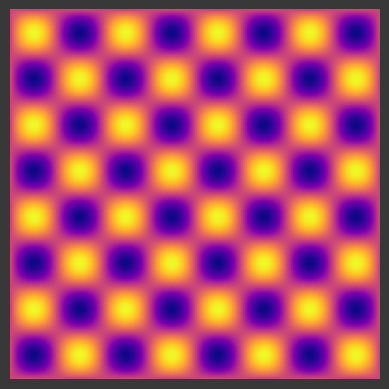

In [23]:

fig = go.Figure()
x = torch.linspace(-4*np.pi,4*np.pi,200)
xx, yy = torch.meshgrid(x,x)
pts = torch.dstack([xx,yy])

pts_fa = pts.reshape(-1,2)
pts_fa = torch.hstack([torch.ones(pts_fa.shape[0], 1), pts_fa])
d = d_fn(pts_fa).flatten()
scat = go.Surface(
    x=xx,
    y=yy,
    z=d.reshape(200,200)
)
fig.add_trace(scat)
fig.show()

plt.figure()
plt.set_cmap("plasma")
plt.imshow(d.reshape(200,200))
plt.axis("off")

In [ ]:

for i in range(15):
  print(f"MetaEpoch: {i}")
  if i == 0:
      pinn.adam.param_groups[0]["lr"] = 1e-3
  if i == 1:
      pinn.adam.param_groups[0]["lr"] = 1e-4
  if i == 2:
      pinn.adam.param_groups[0]["lr"] = 5e-5
  if i == 5:
      pinn.adam.param_groups[0]["lr"] = 1e-5
  if i == 7:
      pinn.adam.param_groups[0]["lr"] = 5e-6
  pinn.train(n_epochs=1000, reporting_frequency=100, phys_weight=1, res_weight=0.01, bc_weight=8, ic_weight=4)

In [6]:
torch.save(pinn.net.state_dict(), "models/bars-2d.pth")

### 2D Diffusion with Discontinuous Diffusivity Field

In [28]:

ADAPTIVE_SAMPLING = True
ADAPTIVE_WEIGHTING = True

t_bounds = [0, 8*np.pi]
s_bounds = [-4*np.pi, 4*np.pi]

d_fn = lambda pts: torch.sigmoid(pts[:,1:2]*6)*16 + torch.sigmoid(pts[:,2:3]*6)*8 + 0.2

bc_l_fn = lambda pinn, pts: pts[:,1:2]*0
bc_r_fn = lambda pinn, pts: pts[:,1:2]*0 
bc_u_fn = lambda pinn, pts: pts[:,1:2]*0 - 2
bc_d_fn = lambda pinn, pts: pts[:,1:2]*0 + 2
bc_l_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_r_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_u_pred_fn = lambda pinn, pts: pinn.net(pts)
bc_d_pred_fn = lambda pinn, pts: pinn.net(pts)

ic_fn = lambda pinn, pts: pts[:,1:2]*0
ic_pred_fn = lambda pinn, pts: pinn.net(pts)


bc_d = BC(
  ct=1000,
  truth_fn=bc_d_fn, 
  pred_fn=bc_d_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[0], s_bounds[0]]], 
  requires_grad=True,
)
bc_u = BC(
  ct=1000,
  truth_fn=bc_u_fn, 
  pred_fn=bc_u_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[1], s_bounds[1]]], 
  requires_grad=True,
)
bc_l = BC(
  ct=1000,
  truth_fn=bc_l_fn,
  pred_fn=bc_l_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[0], s_bounds[0]], s_bounds], 
  requires_grad=True,
)
bc_r = BC(
  ct=1000,
  truth_fn=bc_r_fn,
  pred_fn=bc_r_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[1], s_bounds[1]], s_bounds], 
  requires_grad=True,
)
ic = BC(
  ct=1000,
  truth_fn=ic_fn,
  pred_fn=ic_pred_fn,
  axis_bounds=[[t_bounds[0], t_bounds[0]], s_bounds, s_bounds], 
  requires_grad=False,
)
bcs = [bc_d, bc_u, bc_l, bc_r]
ics = [ic]

pinn = PINN_2D(
    net=MLP(input_dim=3, hidden_layer_ct=4,hidden_dim=256, act=F.tanh, learnable_act="SINGLE"), 
    bcs=bcs,
    ics=ics,
    collocation_ct=2500, 
    d_fn=d_fn,
    t_bounds=t_bounds, 
    space_bounds=s_bounds,
    lr=1e-3,
    adaptive_resample=ADAPTIVE_SAMPLING,
    soft_adapt_weights=ADAPTIVE_WEIGHTING
)

(-0.5, 199.5, 199.5, -0.5)

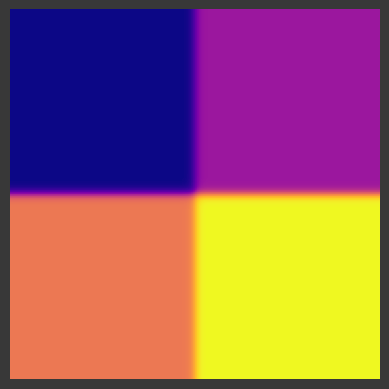

In [29]:
fig = go.Figure()
x = torch.linspace(-4*np.pi,4*np.pi,200)
xx, yy = torch.meshgrid(x,x)
pts = torch.dstack([xx,yy])

pts_fa = pts.reshape(-1,2)
pts_fa = torch.hstack([torch.ones(pts_fa.shape[0], 1), pts_fa])
d = d_fn(pts_fa).flatten()
scat = go.Surface(
    x=xx,
    y=yy,
    z=d.reshape(200,200)
)
fig.add_trace(scat)
fig.show()

plt.figure()
plt.set_cmap("plasma")
plt.imshow(d.reshape(200,200))
plt.axis("off")

In [ ]:
for i in range(15):
  print(f"MetaEpoch: {i}")
  if i == 0:
      pinn.adam.param_groups[0]["lr"] = 1e-3
  if i == 1:
      pinn.adam.param_groups[0]["lr"] = 1e-4
  if i == 2:
      pinn.adam.param_groups[0]["lr"] = 5e-5
  if i == 5:
      pinn.adam.param_groups[0]["lr"] = 1e-5
  if i == 7:
      pinn.adam.param_groups[0]["lr"] = 5e-6
  pinn.train(n_epochs=1000, reporting_frequency=100, phys_weight=1, res_weight=0.01, bc_weight=8, ic_weight=4)

In [31]:
torch.save(pinn.net.state_dict(), "models/plateaus-2d.pth")

### 2D Diffusion with Advection

In [26]:

ADAPTIVE_SAMPLING = True
ADAPTIVE_WEIGHTING = True
t_bounds = [0, 8*np.pi]
s_bounds = [-4*np.pi, 4*np.pi]
d_fn = lambda pts: pts[:,1:2]*0 + 4
v = [0,2]

bc_l_fn = lambda pinn, pts: 1-torch.abs(pts[:,2:3]/pinn.y_range)*2
bc_r_fn = lambda pinn, pts: bc_l_fn(pinn, pts)*-1
bc_l_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_r_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_x"]
bc_u_fn = lambda pinn, pts: pts[:,1:2]*0
bc_d_fn = lambda pinn, pts: pts[:,1:2]*0
bc_u_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_y"]
bc_d_pred_fn = lambda pinn, pts: pinn.heat_flux(pts)["q_y"]


gaussian_height = 15
gaussian_sigma = 5
ic_fn = lambda pinn, pts:  gaussian_height*(1/(gaussian_sigma*np.sqrt(2*np.pi)))*torch.exp(-(get_d(pts)**2) / (2*gaussian_sigma**2))
ic_pred_fn = lambda pinn, pts: pinn.net(pts)

bc_d = BC(
  ct=1000,
  truth_fn=bc_d_fn, 
  pred_fn=bc_d_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[0], s_bounds[0]]], 
  requires_grad=True,
)
bc_u = BC(
  ct=1000,
  truth_fn=bc_u_fn, 
  pred_fn=bc_u_pred_fn,
  axis_bounds=[t_bounds, s_bounds, [s_bounds[1], s_bounds[1]]], 
  requires_grad=True,
)
bc_l = BC(
  ct=1000,
  truth_fn=bc_l_fn,
  pred_fn=bc_l_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[0], s_bounds[0]], s_bounds], 
  requires_grad=True,
)
bc_r = BC(
  ct=1000,
  truth_fn=bc_r_fn,
  pred_fn=bc_r_pred_fn,
  axis_bounds=[t_bounds, [s_bounds[1], s_bounds[1]], s_bounds], 
  requires_grad=True,
)
ic = BC(
  ct=1000,
  truth_fn=ic_fn,
  pred_fn=ic_pred_fn,
  axis_bounds=[[t_bounds[0], t_bounds[0]], s_bounds, s_bounds], 
  requires_grad=False,
)
bcs = [bc_d, bc_u, bc_l, bc_r]
ics = [ic]

pinn = PINN_2D(
    net=MLP(input_dim=3, hidden_layer_ct=4,hidden_dim=256, act=F.tanh, learnable_act="SINGLE"), 
    bcs=bcs,
    ics=ics,
    collocation_ct=2500, 
    d_fn=d_fn,
    t_bounds=t_bounds, 
    space_bounds=s_bounds,
    lr=1e-3,
    v = v,
    adaptive_resample=ADAPTIVE_SAMPLING,
    soft_adapt_weights=ADAPTIVE_WEIGHTING
)
pinn.plot_bcs_and_ics()

In [ ]:
for i in range(15):
  print(f"MetaEpoch: {i}")
  if i == 0:
      pinn.adam.param_groups[0]["lr"] = 1e-3
  if i == 1:
      pinn.adam.param_groups[0]["lr"] = 1e-4
  if i == 2:
      pinn.adam.param_groups[0]["lr"] = 5e-5
  if i == 5:
      pinn.adam.param_groups[0]["lr"] = 1e-5
  if i == 7:
      pinn.adam.param_groups[0]["lr"] = 5e-6
  pinn.train(n_epochs=1000, reporting_frequency=100, phys_weight=1, res_weight=0.01, bc_weight=8, ic_weight=4)

In [18]:
torch.save(pinn.net.state_dict(),"models/heated-sides-with-advecting-gaussian.pth")